In [73]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import skew

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import clone

from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import mean_absolute_error

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
def score_outliers(data, perc1=25, perc3=75):
    q1 = np.percentile(data, perc1)
    q3 = np.percentile(data, perc3)
    iqr = q3 - q1
    outlier_low = q1 - 1.5*iqr
    outlier_high = q3 + 1.5*iqr
    return q1, q3, iqr, outlier_low, outlier_high

In [4]:
def error_metric_cv(model, X, y, scoring="neg_mean_absolute_error", n_cv=5):
    kf = KFold(n_cv, shuffle=True).get_n_splits(X)
    rmse = cross_val_score(model, X, y, scoring=scoring, cv = kf)
    return(rmse)

In [86]:
def neg_error_metric_cv(model, X, y, scoring="neg_mean_absolute_error", n_cv=5):
    return -error_metric_cv(model, X, y, scoring=scoring, n_cv=n_cv)

In [5]:
def error_metric_cv_mean(estimator, X, y, scoring="neg_mean_absolute_error", n_cv=5):
    em = error_metric_cv(estimator, X, y, scoring=scoring, n_cv=cv)
    return em.mean()

In [89]:
def models_cv_stat(models, X, y, scoring="neg_mean_absolute_error", n_cv=5):
    metric = ''.join([l[0] for l in scoring.split('_')][1:])
    stat_df = pd.DataFrame()
    stat_df['model'] = list(models.keys())
    scores = np.array([cross_val_score(m, X, y, cv=n_cv) for m in models.values()])
    stat_df['cv_score_mean'] = scores.mean(axis=-1)
    stat_df['cv_score_std'] = scores.std(axis=-1)
    scores = np.array([neg_error_metric_cv(m, X, y, scoring=scoring, n_cv=n_cv) for m in models.values()])
    stat_df['{}_cv_score_mean'.format(metric)] = scores.mean(axis=-1)
    stat_df['{}_cv_score_std'.format(metric)] = scores.std(axis=-1)
    return stat_df

In [75]:
def models_pred_stat(models, X_train, y_train, X_test, y_test):
    stat_df = pd.DataFrame()
    stat_df['model'] = list(models.keys())
    for Xy_type, X, y in zip(['train', 'test'], [X_train, X_test], [y_train, y_test]):
        y_preds = [m.predict(X) for m in models.values()]
        stat_df['mae_{}'.format(Xy_type)] = [
            mean_absolute_error(np.array(y), y_pred)
            for y_pred in y_preds
        ]
    return stat_df

# Reading src data

In [8]:
src_catalog = './playground-series-s3e14'

### train

In [9]:
train_file = os.path.join(src_catalog, 'train.csv')

In [10]:
train_df = pd.read_csv(train_file, sep=',')
train_df.shape

(15289, 18)

In [11]:
train_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [13]:
train_ids = list(train_df['id'])
len(train_ids)

15289

<AxesSubplot:>

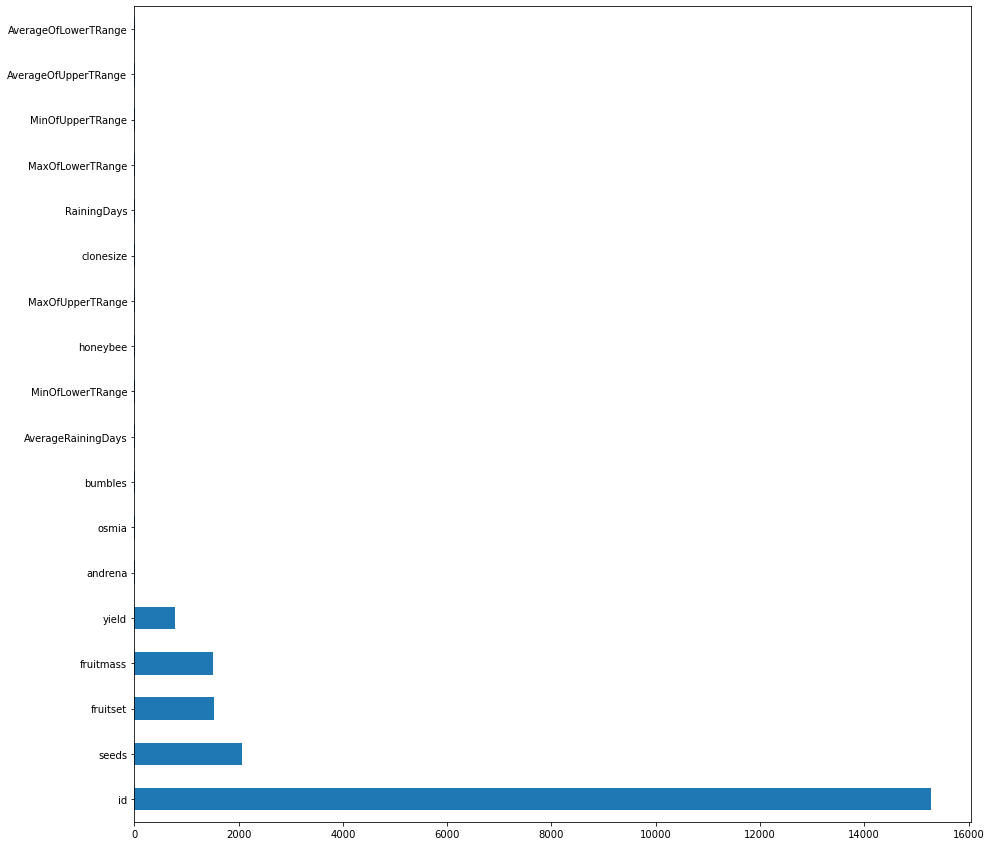

In [14]:
plt.figure(figsize=(15,15))
nunique_train_cols_s = train_df.nunique()
nunique_train_cols_s.sort_values(ascending=False).plot.barh()

### test

In [15]:
test_file = os.path.join(src_catalog, 'test.csv')

In [16]:
test_df = pd.read_csv(test_file, sep=',')
test_df.shape

(10194, 17)

In [17]:
test_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10194 non-null  int64  
 1   clonesize             10194 non-null  float64
 2   honeybee              10194 non-null  float64
 3   bumbles               10194 non-null  float64
 4   andrena               10194 non-null  float64
 5   osmia                 10194 non-null  float64
 6   MaxOfUpperTRange      10194 non-null  float64
 7   MinOfUpperTRange      10194 non-null  float64
 8   AverageOfUpperTRange  10194 non-null  float64
 9   MaxOfLowerTRange      10194 non-null  float64
 10  MinOfLowerTRange      10194 non-null  float64
 11  AverageOfLowerTRange  10194 non-null  float64
 12  RainingDays           10194 non-null  float64
 13  AverageRainingDays    10194 non-null  float64
 14  fruitset              10194 non-null  float64
 15  fruitmass          

In [19]:
test_ids = list(test_df['id'])
len(test_ids)

10194

<AxesSubplot:>

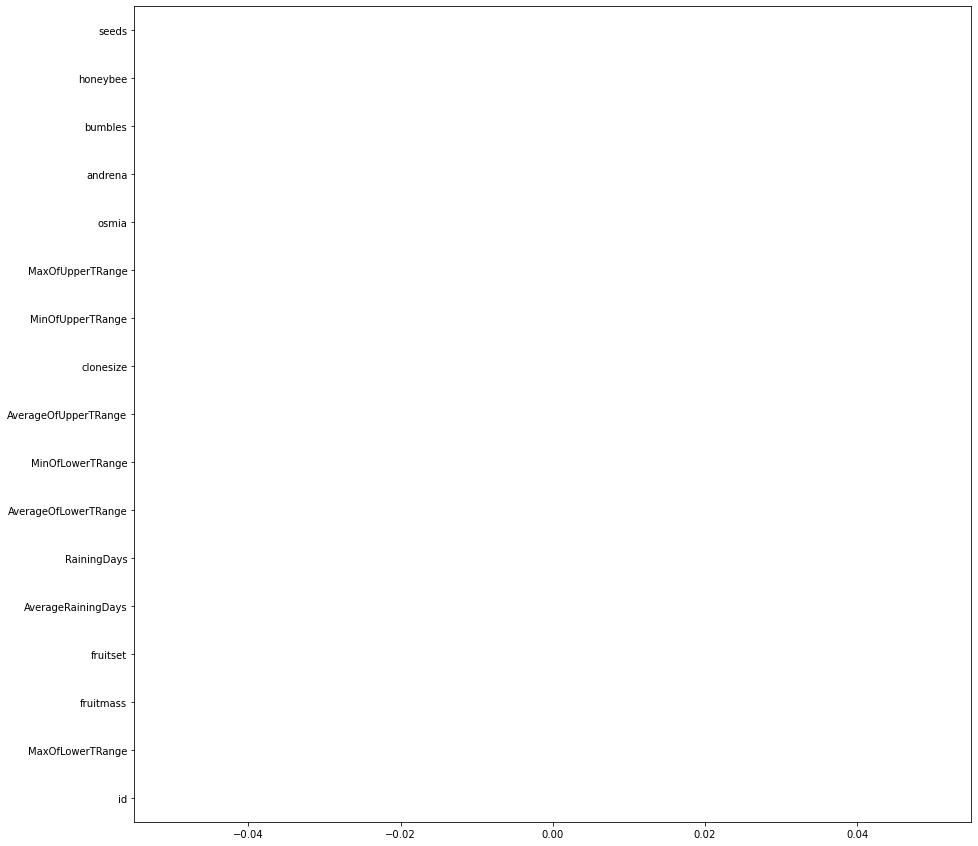

In [20]:
plt.figure(figsize=(15,15))
is_null_test_cols_s = test_df.isnull().sum()
is_null_test_cols_s.sort_values(ascending=False).plot.barh(x='cols', y='null_cnt')

# Analizing train data

### Yield

In [26]:
train_df['yield'].describe()

count    15289.000000
mean      6025.193999
std       1337.056850
min       1945.530610
25%       5128.163510
50%       6117.475900
75%       7019.694380
max       8969.401840
Name: yield, dtype: float64

<AxesSubplot:>

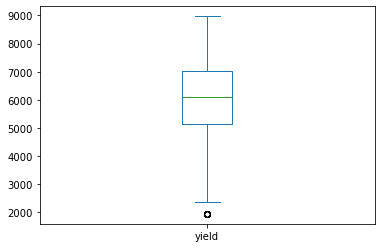

In [27]:
train_df['yield'].plot.box()

<AxesSubplot:xlabel='yield', ylabel='Count'>

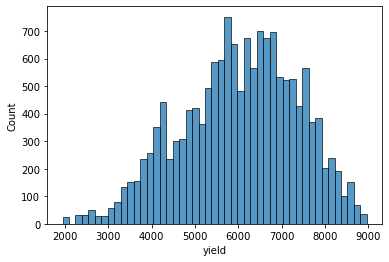

In [28]:
sns.histplot(train_df['yield'])

### Correlation

In [29]:
data_df = pd.concat([train_df, test_df], ignore_index=True)
data_df.pop('yield')
data_df.shape

(25483, 17)

In [30]:
data_corr = data_df.corr()
data_corr.shape

(17, 17)

<AxesSubplot:>

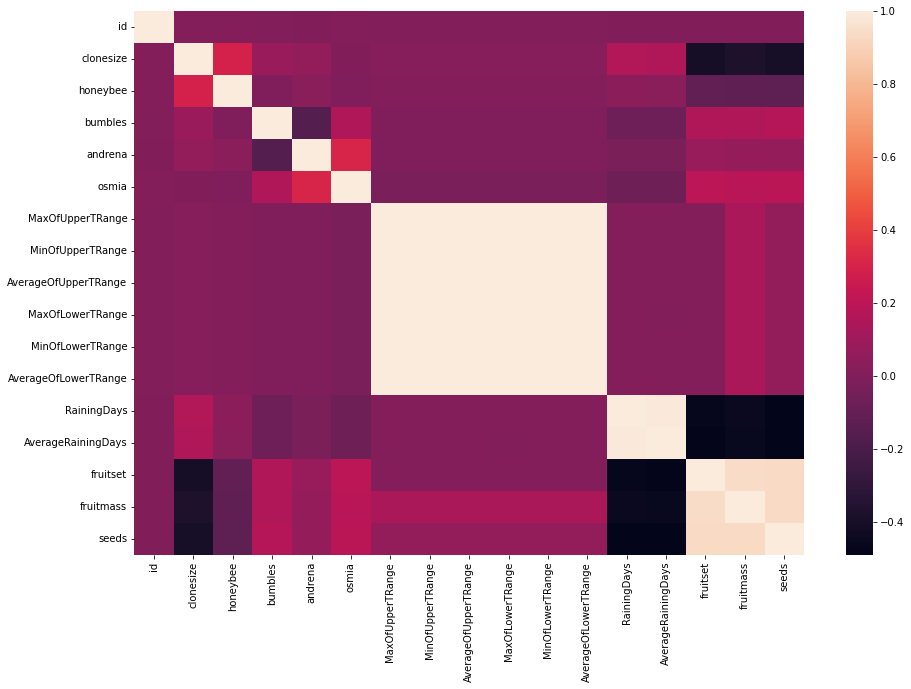

In [31]:
plt.subplots(figsize=(15,10))
sns.heatmap(data_corr)

# Yield predict

In [35]:
col = 'yield'

In [32]:
data_yp_train_df = train_df.copy()
data_yp_train_df.shape

(15289, 18)

In [33]:
data_yp_train_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


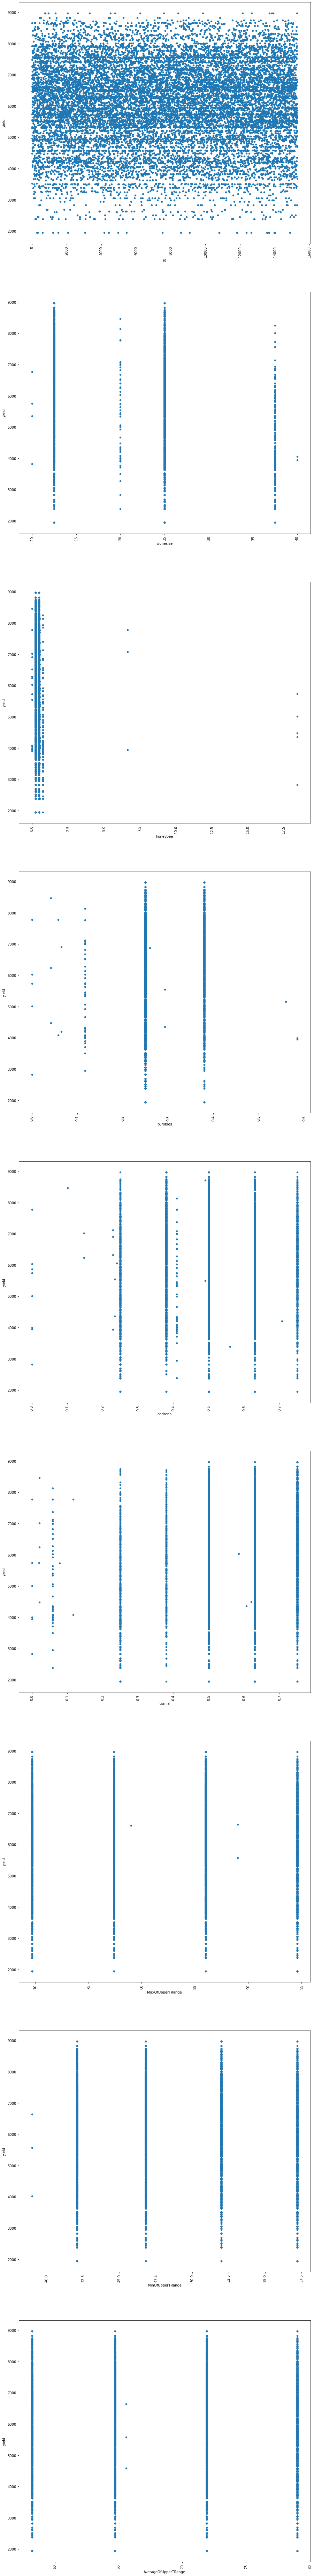

In [36]:
i1 = 0
i2 = int(len(train_df.columns) / 2)
fig, axes = plt.subplots(len(train_df.columns[i1:i2]), 1, figsize=(15,15*(i2-i1)))
for i, c in enumerate(train_df.columns[i1:i2]):
    if c in data_yp_train_df.columns:        
        train_df.get([c, col]).dropna().plot.scatter(x=c, y=col, ax=axes[i], rot=90)

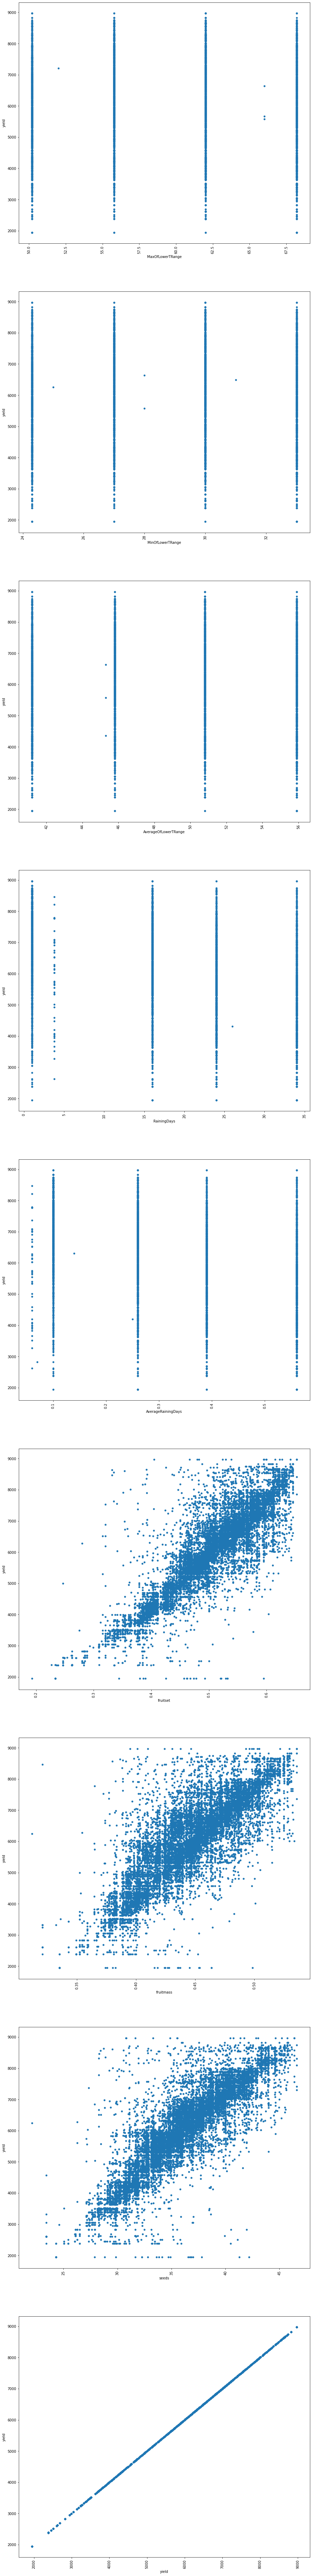

In [37]:
i1 = int(len(train_df.columns) / 2)
i2 = len(train_df.columns)
fig, axes = plt.subplots(len(train_df.columns[i1:i2]), 1, figsize=(15,15*(i2-i1)))
for i, c in enumerate(train_df.columns[i1:i2]):
    if c in data_yp_train_df.columns:        
        train_df.get([c, col]).dropna().plot.scatter(x=c, y=col, ax=axes[i], rot=90)

##### Outliers

In [38]:
linear_cols = [
    'fruitset',
    'fruitmass',
    'seeds'
]

In [39]:
linear_thresholds = dict()
for c in linear_cols + [col]:
    _, _, _, _, linear_thresholds[c] = score_outliers(data_yp_train_df[c].dropna())
linear_thresholds[col]

9856.990684999999

In [40]:
data_thr_df = data_yp_train_df.copy()
for c in linear_cols + [col]:
    data_thr_df = data_thr_df[data_thr_df[c] <= linear_thresholds[c]]
data_thr_df.shape

(15289, 18)

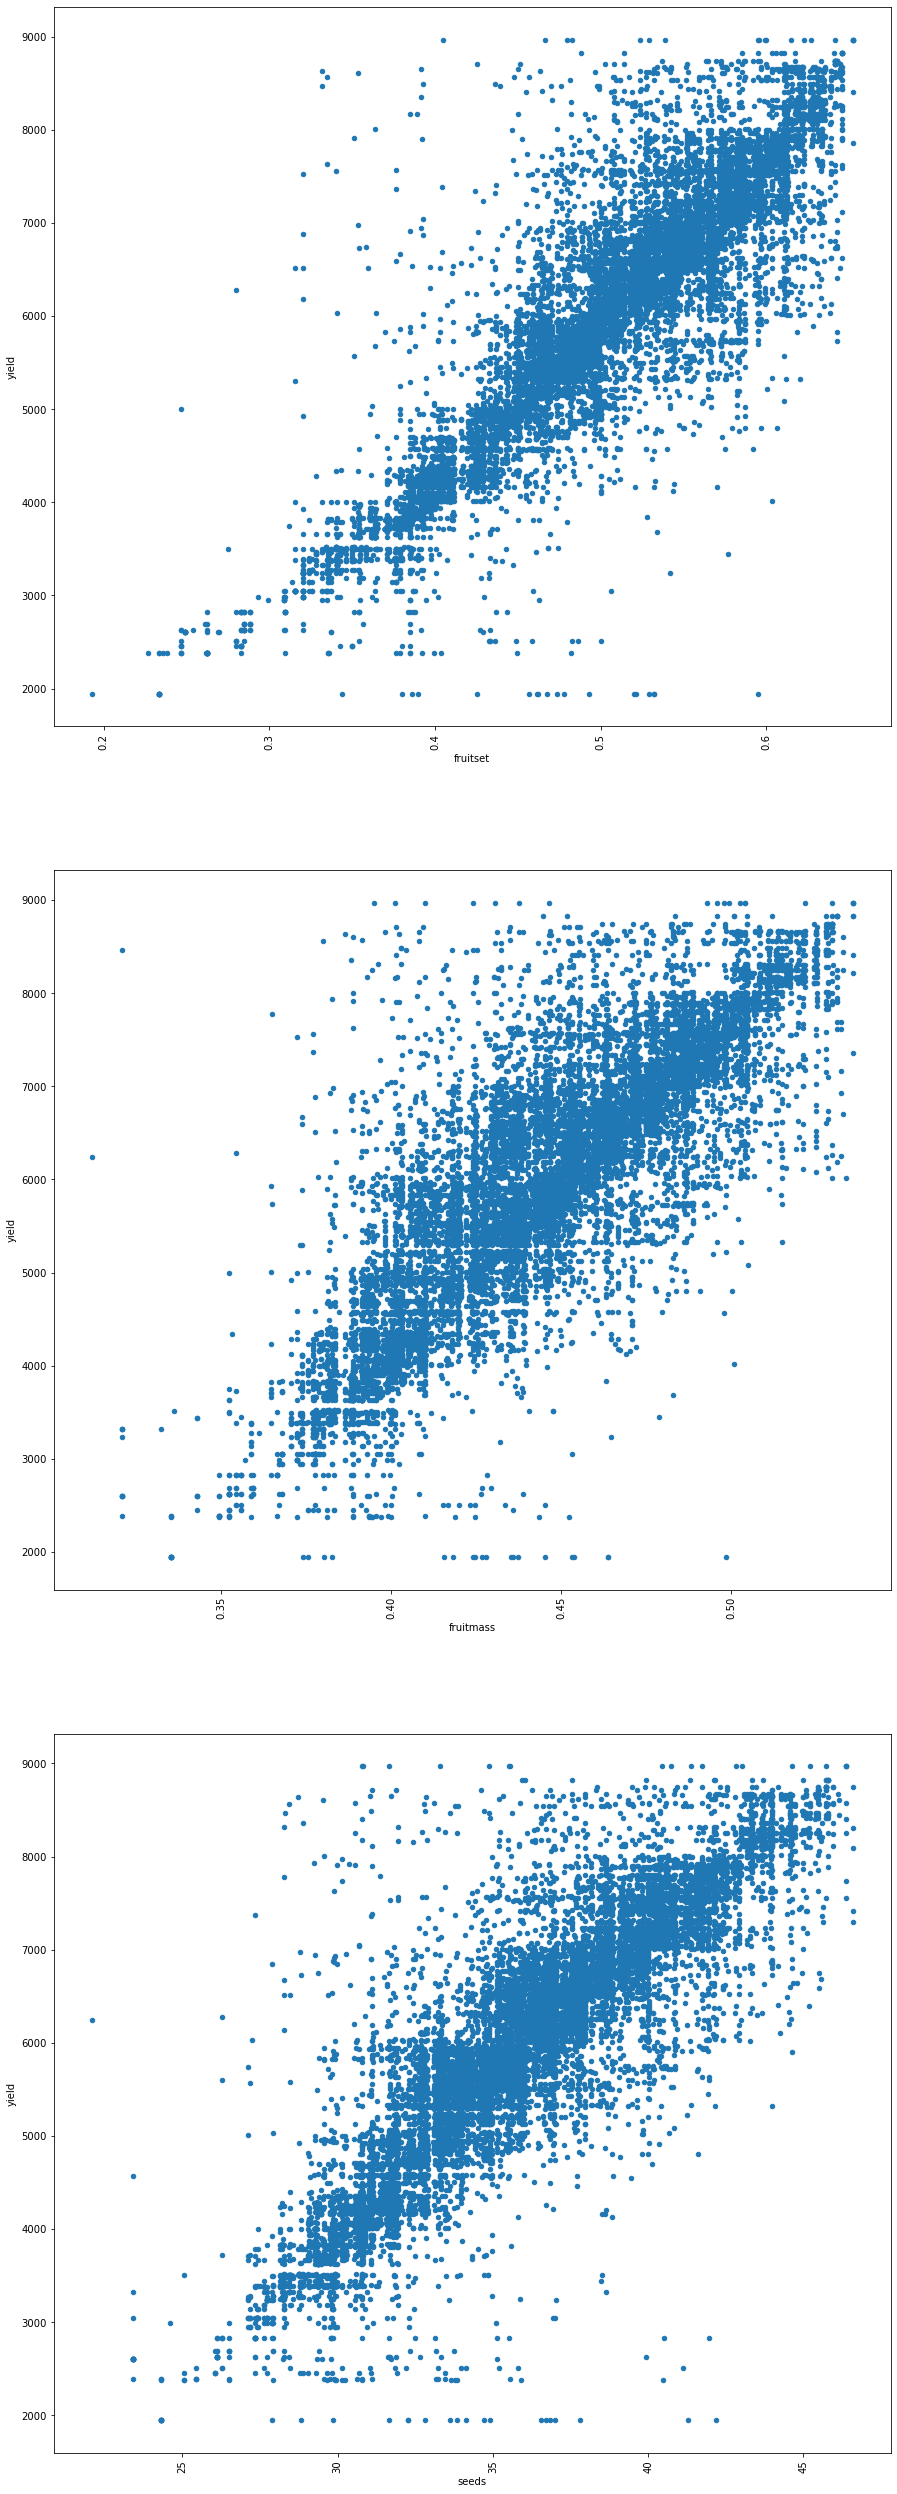

In [41]:
fig, axes = plt.subplots(len(linear_cols), 1, figsize=(15,15*len(linear_cols)))
for i, c in enumerate(linear_cols):
    data_thr_df.get([c, col]).dropna().plot.scatter(x=c, y=col, ax=axes[i], rot=90)

### Regression

In [42]:
X = data_thr_df.copy()
X.pop(col)
X.pop('id')
y = data_thr_df[col]
X.shape, y.shape

((15289, 16), (15289,))

In [43]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((11466, 16), (3823, 16), (11466,), (3823,))

##### Ridge

In [45]:
ridge_model = Pipeline(steps=[('robast', RobustScaler()), ('ridge', KernelRidge(kernel='polynomial'))])

In [46]:
param_grid = {
    'ridge__alpha': [1, 0.1, 0.01],
    'ridge__degree': range(2, 4),
}

ridge_grid_search = GridSearchCV(ridge_model, param_grid=param_grid, scoring='neg_mean_absolute_error')

In [48]:
ridge_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('robast', RobustScaler()),
                                       ('ridge',
                                        KernelRidge(kernel='polynomial'))]),
             param_grid={'ridge__alpha': [1, 0.1, 0.01],
                         'ridge__degree': range(2, 4)},
             scoring='neg_mean_absolute_error')

In [49]:
ridge_grid_search.best_params_

{'ridge__alpha': 1, 'ridge__degree': 2}

In [50]:
ridge_grid_search.best_score_

-368.5474037150913

In [51]:
alpha = ridge_grid_search.best_params_['ridge__alpha']
degree = ridge_grid_search.best_params_['ridge__degree']

ridge_model = Pipeline(
    steps=[
        ('robast', RobustScaler()),
        ('ridge', KernelRidge(alpha=alpha, kernel='polynomial', degree=degree))
    ]
)
ridge_model

Pipeline(steps=[('robast', RobustScaler()),
                ('ridge', KernelRidge(degree=2, kernel='polynomial'))])

##### Lasso

In [52]:
lasso_model = Pipeline(steps=[('robast', RobustScaler()), ('lasso', Lasso())])

In [81]:
param_grid = {
    'lasso__alpha': [1, 0.1, 0.01],
}

lasso_grid_search = GridSearchCV(lasso_model, param_grid=param_grid, scoring='neg_mean_absolute_error')

In [82]:
lasso_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('robast', RobustScaler()),
                                       ('lasso', Lasso(alpha=1))]),
             param_grid={'lasso__alpha': [1, 0.1, 0.01]},
             scoring='neg_mean_absolute_error')

In [55]:
lasso_grid_search.best_params_

{'lasso__alpha': 1}

In [56]:
lasso_grid_search.best_score_

-370.17116242478915

In [57]:
alpha = lasso_grid_search.best_params_['lasso__alpha']

lasso_model = Pipeline(
    steps=[
        ('robast', RobustScaler()),
        ('lasso', Lasso(alpha=alpha))
    ]
)
lasso_model

Pipeline(steps=[('robast', RobustScaler()), ('lasso', Lasso(alpha=1))])

##### ElasticNet

In [58]:
enet_model = Pipeline(steps=[('robast', RobustScaler()), ('enet', ElasticNet())])

In [79]:
param_grid = {
    'enet__alpha': [0.1, 0.01, 0.001],
    'enet__l1_ratio': [0.25, 0.5, 0.75]
}

enet_grid_search = GridSearchCV(enet_model, param_grid=param_grid, scoring='neg_mean_absolute_error')

In [80]:
enet_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('robast', RobustScaler()),
                                       ('enet',
                                        ElasticNet(alpha=0.001,
                                                   l1_ratio=0.75))]),
             param_grid={'enet__alpha': [0.1, 0.01, 0.001],
                         'enet__l1_ratio': [0.25, 0.5, 0.75]},
             scoring='neg_mean_absolute_error')

In [61]:
enet_grid_search.best_params_

{'enet__alpha': 0.001, 'enet__l1_ratio': 0.75}

In [62]:
enet_grid_search.best_score_

-370.31560596606676

In [63]:
alpha = enet_grid_search.best_params_['enet__alpha']
l1_ratio = enet_grid_search.best_params_['enet__l1_ratio']

enet_model = Pipeline(
    steps=[
        ('robast', RobustScaler()),
        ('enet', ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
    ]
)
enet_model

Pipeline(steps=[('robast', RobustScaler()),
                ('enet', ElasticNet(alpha=0.001, l1_ratio=0.75))])

##### Random Forest

In [64]:
max_depth = 5
n_estimators = 5000

rf_model = Pipeline(
    steps=[
        ('robast', RobustScaler()),
        ('rf', RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators))
    ]
)
rf_model

Pipeline(steps=[('robast', RobustScaler()),
                ('rf', RandomForestRegressor(max_depth=5, n_estimators=5000))])

##### GradientBoostingRegressor

In [65]:
learning_rate=0.01
max_depth=5
n_estimators=5000


gbr_model = Pipeline(
    steps=[
        ('robast', RobustScaler()),
        ('gbr', GradientBoostingRegressor(
            loss='absolute_error',
            learning_rate=learning_rate, 
            max_depth=max_depth, 
            n_estimators=n_estimators)
        )
    ]
)
gbr_model

Pipeline(steps=[('robast', RobustScaler()),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.01,
                                           loss='absolute_error', max_depth=5,
                                           n_estimators=5000))])

##### XGBoost

In [66]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', eval_metrics='mae', n_estimators=10000, max_depth=7, eta=0.07, gamma=0.0,
    reg_alpha= 0.1,
    reg_lambda = 100.0,
    verbosity=0
)
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.07, eval_metric=None,
             eval_metrics='mae', feature_types=None, gamma=0.0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None, ...)

##### CatBoost

In [67]:
cb_model = CatBoostRegressor(
    depth=3,
    learning_rate=0.01,
    reg_lambda = 1000.0,
    logging_level='Silent',
    iterations=5000,
    loss_function='MAE',
    early_stopping_rounds=100,
)

##### Models statistics

In [68]:
models = {
    'Ridge': ridge_model,
    'Lasso': lasso_model,
    'Elastic Net': enet_model,
    'Random Forest': rf_model,
    'Gradient Boosting Regressor': gbr_model,
    'XGBoost': xgb_model,
    'CatBoost': cb_model
}

In [85]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [88]:
models_cv_stat(models, X, y, n_cv=5)

,model,cv_score_mean,cv_score_std,nmae_cv_score_mean,nmae_cv_score_std
0,Ridge,0.812697,0.011361,368.914930,4.412502
1,Lasso,0.809227,0.010425,371.971951,4.542587
2,Elastic Net,0.809215,0.010516,372.149209,4.662868
3,Random Forest,0.816194,0.009894,360.659706,2.941074
4,Gradient Boosting Regressor,0.819871,0.011412,345.685917,3.634515
5,XGBoost,0.786718,0.010557,411.334980,5.386898
6,CatBoost,0.820513,0.011452,344.068293,4.067402


In [83]:
prep_models = dict()
for m_name, m in models.items():
    prep_models[m_name] = clone(m)
    if m_name == 'XGBoost':
        prep_models[m_name].fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_validation, y_validation)],
            early_stopping_rounds=100,
            verbose=True
        )
    elif m_name =='CatBoost':
        prep_models[m_name].fit(
            X_train, y_train,
            eval_set=(X_validation, y_validation),
            logging_level='Verbose',
            plot=True
        )
    else:
        prep_models[m_name].fit(X_train, y_train)

[0]	validation_0-rmse:5757.79420	validation_1-rmse:5748.75639
[1]	validation_0-rmse:5370.31920	validation_1-rmse:5360.40871
[2]	validation_0-rmse:5010.16454	validation_1-rmse:5000.27731
[3]	validation_0-rmse:4675.18460	validation_1-rmse:4665.04801
[4]	validation_0-rmse:4363.14793	validation_1-rmse:4352.36112
[5]	validation_0-rmse:4072.64050	validation_1-rmse:4062.09415
[6]	validation_0-rmse:3802.63598	validation_1-rmse:3791.47553
[7]	validation_0-rmse:3551.30697	validation_1-rmse:3540.47727
[8]	validation_0-rmse:3317.76850	validation_1-rmse:3306.62099
[9]	validation_0-rmse:3100.66035	validation_1-rmse:3089.52767
[10]	validation_0-rmse:2898.82938	validation_1-rmse:2887.74551
[11]	validation_0-rmse:2711.35125	validation_1-rmse:2700.77357
[12]	validation_0-rmse:2537.26296	validation_1-rmse:2527.70700
[13]	validation_0-rmse:2375.68810	validation_1-rmse:2366.18810
[14]	validation_0-rmse:2225.31685	validation_1-rmse:2216.22878
[15]	validation_0-rmse:2085.84667	validation_1-rmse:2077.30921
[1

[134]	validation_0-rmse:529.69017	validation_1-rmse:559.34365
[135]	validation_0-rmse:529.56853	validation_1-rmse:559.36133
[136]	validation_0-rmse:529.33938	validation_1-rmse:559.31440
[137]	validation_0-rmse:529.20808	validation_1-rmse:559.30094
[138]	validation_0-rmse:529.08910	validation_1-rmse:559.27511
[139]	validation_0-rmse:528.88039	validation_1-rmse:559.25338
[140]	validation_0-rmse:528.75799	validation_1-rmse:559.22934
[141]	validation_0-rmse:528.57361	validation_1-rmse:559.27549
[142]	validation_0-rmse:528.37662	validation_1-rmse:559.21742
[143]	validation_0-rmse:528.20943	validation_1-rmse:559.21615
[144]	validation_0-rmse:528.07251	validation_1-rmse:559.26087
[145]	validation_0-rmse:527.95617	validation_1-rmse:559.24418
[146]	validation_0-rmse:527.85024	validation_1-rmse:559.23720
[147]	validation_0-rmse:527.62093	validation_1-rmse:559.17194
[148]	validation_0-rmse:527.29808	validation_1-rmse:559.16748
[149]	validation_0-rmse:527.16750	validation_1-rmse:559.21704
[150]	va

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1083.7346597	test: 1077.2778662	best: 1077.2778662 (0)	total: 3.56ms	remaining: 17.8s
1:	learn: 1074.9702541	test: 1068.5961102	best: 1068.5961102 (1)	total: 7.32ms	remaining: 18.3s
2:	learn: 1066.9185673	test: 1060.7752248	best: 1060.7752248 (2)	total: 13.4ms	remaining: 22.3s
3:	learn: 1059.3534537	test: 1053.3889050	best: 1053.3889050 (3)	total: 19.3ms	remaining: 24.1s
4:	learn: 1051.5814178	test: 1045.8073108	best: 1045.8073108 (4)	total: 24.2ms	remaining: 24.1s
5:	learn: 1044.1229291	test: 1038.4975621	best: 1038.4975621 (5)	total: 28.8ms	remaining: 23.9s
6:	learn: 1036.4847950	test: 1031.0595921	best: 1031.0595921 (6)	total: 32.6ms	remaining: 23.3s
7:	learn: 1029.0795158	test: 1023.7948037	best: 1023.7948037 (7)	total: 37.4ms	remaining: 23.4s
8:	learn: 1021.9158462	test: 1016.7927371	best: 1016.7927371 (8)	total: 40.6ms	remaining: 22.5s
9:	learn: 1014.5849232	test: 1009.6602674	best: 1009.6602674 (9)	total: 43.7ms	remaining: 21.8s
10:	learn: 1007.3485443	test: 1002.63213

104:	learn: 596.3128503	test: 601.0427520	best: 601.0427520 (104)	total: 329ms	remaining: 15.4s
105:	learn: 593.7131816	test: 598.4733470	best: 598.4733470 (105)	total: 332ms	remaining: 15.3s
106:	learn: 591.0107171	test: 595.7897930	best: 595.7897930 (106)	total: 335ms	remaining: 15.3s
107:	learn: 588.6045639	test: 593.4180916	best: 593.4180916 (107)	total: 338ms	remaining: 15.3s
108:	learn: 585.9797637	test: 590.8239769	best: 590.8239769 (108)	total: 342ms	remaining: 15.4s
109:	learn: 583.3584387	test: 588.2593233	best: 588.2593233 (109)	total: 348ms	remaining: 15.5s
110:	learn: 580.8501837	test: 585.8289830	best: 585.8289830 (110)	total: 352ms	remaining: 15.5s
111:	learn: 578.2938907	test: 583.3341833	best: 583.3341833 (111)	total: 357ms	remaining: 15.6s
112:	learn: 576.1182900	test: 581.2211675	best: 581.2211675 (112)	total: 362ms	remaining: 15.6s
113:	learn: 573.6037024	test: 578.7775690	best: 578.7775690 (113)	total: 368ms	remaining: 15.8s
114:	learn: 571.1211381	test: 576.372094

206:	learn: 440.4493138	test: 448.0527677	best: 448.0527677 (206)	total: 665ms	remaining: 15.4s
207:	learn: 439.5537892	test: 447.1956752	best: 447.1956752 (207)	total: 668ms	remaining: 15.4s
208:	learn: 438.6937277	test: 446.3494853	best: 446.3494853 (208)	total: 671ms	remaining: 15.4s
209:	learn: 437.9392137	test: 445.5870875	best: 445.5870875 (209)	total: 674ms	remaining: 15.4s
210:	learn: 437.0823268	test: 444.7434071	best: 444.7434071 (210)	total: 677ms	remaining: 15.4s
211:	learn: 436.2455120	test: 443.9125751	best: 443.9125751 (211)	total: 680ms	remaining: 15.4s
212:	learn: 435.4586866	test: 443.1621323	best: 443.1621323 (212)	total: 683ms	remaining: 15.4s
213:	learn: 434.7646298	test: 442.4604771	best: 442.4604771 (213)	total: 686ms	remaining: 15.4s
214:	learn: 433.9280783	test: 441.6452659	best: 441.6452659 (214)	total: 689ms	remaining: 15.3s
215:	learn: 433.1895858	test: 440.8886446	best: 440.8886446 (215)	total: 692ms	remaining: 15.3s
216:	learn: 432.3783238	test: 440.095453

297:	learn: 389.8482567	test: 397.2985689	best: 397.2985689 (297)	total: 1.03s	remaining: 16.2s
298:	learn: 389.4994423	test: 396.9592698	best: 396.9592698 (298)	total: 1.03s	remaining: 16.3s
299:	learn: 389.1077810	test: 396.5546349	best: 396.5546349 (299)	total: 1.04s	remaining: 16.3s
300:	learn: 388.6823208	test: 396.1251186	best: 396.1251186 (300)	total: 1.04s	remaining: 16.3s
301:	learn: 388.2936665	test: 395.7334301	best: 395.7334301 (301)	total: 1.04s	remaining: 16.2s
302:	learn: 387.9007156	test: 395.3265493	best: 395.3265493 (302)	total: 1.05s	remaining: 16.2s
303:	learn: 387.5668481	test: 394.9822524	best: 394.9822524 (303)	total: 1.05s	remaining: 16.3s
304:	learn: 387.1812223	test: 394.5927591	best: 394.5927591 (304)	total: 1.05s	remaining: 16.3s
305:	learn: 386.9160966	test: 394.3210613	best: 394.3210613 (305)	total: 1.06s	remaining: 16.2s
306:	learn: 386.5787382	test: 393.9835466	best: 393.9835466 (306)	total: 1.06s	remaining: 16.2s
307:	learn: 386.2515227	test: 393.643014

385:	learn: 368.6110042	test: 375.8856151	best: 375.8856151 (385)	total: 1.35s	remaining: 16.1s
386:	learn: 368.4648067	test: 375.7300302	best: 375.7300302 (386)	total: 1.35s	remaining: 16.1s
387:	learn: 368.3400155	test: 375.5832103	best: 375.5832103 (387)	total: 1.35s	remaining: 16.1s
388:	learn: 368.2018873	test: 375.4286632	best: 375.4286632 (388)	total: 1.36s	remaining: 16.1s
389:	learn: 368.0500802	test: 375.2841700	best: 375.2841700 (389)	total: 1.36s	remaining: 16.1s
390:	learn: 367.9284969	test: 375.1672662	best: 375.1672662 (390)	total: 1.36s	remaining: 16.1s
391:	learn: 367.8025426	test: 375.0347528	best: 375.0347528 (391)	total: 1.36s	remaining: 16.1s
392:	learn: 367.6566578	test: 374.8958714	best: 374.8958714 (392)	total: 1.37s	remaining: 16.1s
393:	learn: 367.4952574	test: 374.7259572	best: 374.7259572 (393)	total: 1.38s	remaining: 16.1s
394:	learn: 367.3360503	test: 374.5555623	best: 374.5555623 (394)	total: 1.38s	remaining: 16.1s
395:	learn: 367.2446878	test: 374.461894

502:	learn: 358.2216370	test: 364.2696840	best: 364.2696840 (502)	total: 1.89s	remaining: 16.9s
503:	learn: 358.1514151	test: 364.1871446	best: 364.1871446 (503)	total: 1.89s	remaining: 16.9s
504:	learn: 358.1010081	test: 364.1310538	best: 364.1310538 (504)	total: 1.9s	remaining: 16.9s
505:	learn: 358.0573334	test: 364.0818085	best: 364.0818085 (505)	total: 1.9s	remaining: 16.9s
506:	learn: 357.9735259	test: 363.9962903	best: 363.9962903 (506)	total: 1.9s	remaining: 16.9s
507:	learn: 357.9244611	test: 363.9357043	best: 363.9357043 (507)	total: 1.91s	remaining: 16.9s
508:	learn: 357.8704301	test: 363.8847076	best: 363.8847076 (508)	total: 1.91s	remaining: 16.9s
509:	learn: 357.8216684	test: 363.8249318	best: 363.8249318 (509)	total: 1.91s	remaining: 16.9s
510:	learn: 357.7729502	test: 363.7643027	best: 363.7643027 (510)	total: 1.92s	remaining: 16.8s
511:	learn: 357.7040915	test: 363.6848693	best: 363.6848693 (511)	total: 1.92s	remaining: 16.8s
512:	learn: 357.6420557	test: 363.6112929	b

603:	learn: 353.9547419	test: 359.5458394	best: 359.5458394 (603)	total: 2.22s	remaining: 16.2s
604:	learn: 353.9353938	test: 359.5286103	best: 359.5286103 (604)	total: 2.23s	remaining: 16.2s
605:	learn: 353.8898143	test: 359.4772497	best: 359.4772497 (605)	total: 2.23s	remaining: 16.2s
606:	learn: 353.8647515	test: 359.4425899	best: 359.4425899 (606)	total: 2.23s	remaining: 16.1s
607:	learn: 353.8298964	test: 359.4042239	best: 359.4042239 (607)	total: 2.24s	remaining: 16.2s
608:	learn: 353.7846260	test: 359.3603256	best: 359.3603256 (608)	total: 2.24s	remaining: 16.1s
609:	learn: 353.7536607	test: 359.3231591	best: 359.3231591 (609)	total: 2.24s	remaining: 16.1s
610:	learn: 353.7302820	test: 359.2945800	best: 359.2945800 (610)	total: 2.24s	remaining: 16.1s
611:	learn: 353.6879120	test: 359.2427399	best: 359.2427399 (611)	total: 2.25s	remaining: 16.1s
612:	learn: 353.6460015	test: 359.1983294	best: 359.1983294 (612)	total: 2.25s	remaining: 16.1s
613:	learn: 353.5928837	test: 359.139369

691:	learn: 351.3954936	test: 356.6976806	best: 356.6976806 (691)	total: 2.55s	remaining: 15.9s
692:	learn: 351.3786524	test: 356.6790047	best: 356.6790047 (692)	total: 2.56s	remaining: 15.9s
693:	learn: 351.3599441	test: 356.6586164	best: 356.6586164 (693)	total: 2.56s	remaining: 15.9s
694:	learn: 351.3367141	test: 356.6343643	best: 356.6343643 (694)	total: 2.56s	remaining: 15.9s
695:	learn: 351.3193562	test: 356.6211716	best: 356.6211716 (695)	total: 2.56s	remaining: 15.9s
696:	learn: 351.2890334	test: 356.5858848	best: 356.5858848 (696)	total: 2.57s	remaining: 15.9s
697:	learn: 351.2705233	test: 356.5676944	best: 356.5676944 (697)	total: 2.57s	remaining: 15.8s
698:	learn: 351.2405893	test: 356.5332267	best: 356.5332267 (698)	total: 2.57s	remaining: 15.8s
699:	learn: 351.2129118	test: 356.5015777	best: 356.5015777 (699)	total: 2.59s	remaining: 15.9s
700:	learn: 351.1997460	test: 356.4920320	best: 356.4920320 (700)	total: 2.59s	remaining: 15.9s
701:	learn: 351.1724769	test: 356.459124

781:	learn: 349.9218112	test: 355.0662518	best: 355.0662518 (781)	total: 2.89s	remaining: 15.6s
782:	learn: 349.9060151	test: 355.0461729	best: 355.0461729 (782)	total: 2.9s	remaining: 15.6s
783:	learn: 349.8925680	test: 355.0249146	best: 355.0249146 (783)	total: 2.9s	remaining: 15.6s
784:	learn: 349.8811912	test: 355.0099215	best: 355.0099215 (784)	total: 2.9s	remaining: 15.6s
785:	learn: 349.8691505	test: 354.9942933	best: 354.9942933 (785)	total: 2.91s	remaining: 15.6s
786:	learn: 349.8535210	test: 354.9853902	best: 354.9853902 (786)	total: 2.91s	remaining: 15.6s
787:	learn: 349.8453336	test: 354.9835521	best: 354.9835521 (787)	total: 2.92s	remaining: 15.6s
788:	learn: 349.8360095	test: 354.9771767	best: 354.9771767 (788)	total: 2.92s	remaining: 15.6s
789:	learn: 349.8273460	test: 354.9698186	best: 354.9698186 (789)	total: 2.92s	remaining: 15.6s
790:	learn: 349.8128026	test: 354.9578495	best: 354.9578495 (790)	total: 2.93s	remaining: 15.6s
791:	learn: 349.7995458	test: 354.9502209	b

877:	learn: 348.8212667	test: 353.9915495	best: 353.9915495 (877)	total: 3.4s	remaining: 16s
878:	learn: 348.8067920	test: 353.9713534	best: 353.9713534 (878)	total: 3.4s	remaining: 16s
879:	learn: 348.8011645	test: 353.9668520	best: 353.9668520 (879)	total: 3.41s	remaining: 16s
880:	learn: 348.7903242	test: 353.9513311	best: 353.9513311 (880)	total: 3.42s	remaining: 16s
881:	learn: 348.7825448	test: 353.9420079	best: 353.9420079 (881)	total: 3.42s	remaining: 16s
882:	learn: 348.7714897	test: 353.9285359	best: 353.9285359 (882)	total: 3.42s	remaining: 16s
883:	learn: 348.7632865	test: 353.9204053	best: 353.9204053 (883)	total: 3.43s	remaining: 16s
884:	learn: 348.7526432	test: 353.9059649	best: 353.9059649 (884)	total: 3.43s	remaining: 16s
885:	learn: 348.7419681	test: 353.8964508	best: 353.8964508 (885)	total: 3.44s	remaining: 16s
886:	learn: 348.7189454	test: 353.8787080	best: 353.8787080 (886)	total: 3.44s	remaining: 16s
887:	learn: 348.7150360	test: 353.8772950	best: 353.8772950 (8

997:	learn: 347.5654440	test: 352.7217805	best: 352.7217805 (997)	total: 3.89s	remaining: 15.6s
998:	learn: 347.5556870	test: 352.7093114	best: 352.7093114 (998)	total: 3.89s	remaining: 15.6s
999:	learn: 347.5479278	test: 352.7000551	best: 352.7000551 (999)	total: 3.9s	remaining: 15.6s
1000:	learn: 347.5411861	test: 352.6912593	best: 352.6912593 (1000)	total: 3.9s	remaining: 15.6s
1001:	learn: 347.5328192	test: 352.6832678	best: 352.6832678 (1001)	total: 3.9s	remaining: 15.6s
1002:	learn: 347.5250579	test: 352.6780215	best: 352.6780215 (1002)	total: 3.91s	remaining: 15.6s
1003:	learn: 347.5192798	test: 352.6697176	best: 352.6697176 (1003)	total: 3.91s	remaining: 15.6s
1004:	learn: 347.5111613	test: 352.6732147	best: 352.6697176 (1003)	total: 3.91s	remaining: 15.6s
1005:	learn: 347.5077615	test: 352.6701964	best: 352.6697176 (1003)	total: 3.92s	remaining: 15.6s
1006:	learn: 347.4991880	test: 352.6581184	best: 352.6581184 (1006)	total: 3.92s	remaining: 15.6s
1007:	learn: 347.4914320	test

1088:	learn: 346.7672501	test: 352.0879647	best: 352.0879647 (1088)	total: 4.22s	remaining: 15.2s
1089:	learn: 346.7593419	test: 352.0826637	best: 352.0826637 (1089)	total: 4.22s	remaining: 15.2s
1090:	learn: 346.7432864	test: 352.0686079	best: 352.0686079 (1090)	total: 4.23s	remaining: 15.2s
1091:	learn: 346.7412209	test: 352.0676726	best: 352.0676726 (1091)	total: 4.23s	remaining: 15.1s
1092:	learn: 346.7357669	test: 352.0690514	best: 352.0676726 (1091)	total: 4.24s	remaining: 15.1s
1093:	learn: 346.7244520	test: 352.0655225	best: 352.0655225 (1093)	total: 4.24s	remaining: 15.1s
1094:	learn: 346.7193798	test: 352.0581440	best: 352.0581440 (1094)	total: 4.24s	remaining: 15.1s
1095:	learn: 346.7056263	test: 352.0414832	best: 352.0414832 (1095)	total: 4.25s	remaining: 15.1s
1096:	learn: 346.7021180	test: 352.0386245	best: 352.0386245 (1096)	total: 4.25s	remaining: 15.1s
1097:	learn: 346.6843397	test: 352.0306385	best: 352.0306385 (1097)	total: 4.25s	remaining: 15.1s
1098:	learn: 346.676

1177:	learn: 345.9038723	test: 351.5193423	best: 351.5193423 (1177)	total: 4.58s	remaining: 14.9s
1178:	learn: 345.8910916	test: 351.5161937	best: 351.5161937 (1178)	total: 4.58s	remaining: 14.9s
1179:	learn: 345.8846874	test: 351.5160206	best: 351.5160206 (1179)	total: 4.59s	remaining: 14.9s
1180:	learn: 345.8815417	test: 351.5118979	best: 351.5118979 (1180)	total: 4.59s	remaining: 14.8s
1181:	learn: 345.8672403	test: 351.5049730	best: 351.5049730 (1181)	total: 4.6s	remaining: 14.9s
1182:	learn: 345.8628250	test: 351.5010691	best: 351.5010691 (1182)	total: 4.6s	remaining: 14.9s
1183:	learn: 345.8601897	test: 351.4983969	best: 351.4983969 (1183)	total: 4.61s	remaining: 14.9s
1184:	learn: 345.8558811	test: 351.4953578	best: 351.4953578 (1184)	total: 4.61s	remaining: 14.8s
1185:	learn: 345.8489374	test: 351.4879630	best: 351.4879630 (1185)	total: 4.62s	remaining: 14.8s
1186:	learn: 345.8384198	test: 351.4784853	best: 351.4784853 (1186)	total: 4.62s	remaining: 14.8s
1187:	learn: 345.83329

1263:	learn: 345.1870114	test: 351.0768371	best: 351.0768371 (1263)	total: 4.91s	remaining: 14.5s
1264:	learn: 345.1834622	test: 351.0749168	best: 351.0749168 (1264)	total: 4.91s	remaining: 14.5s
1265:	learn: 345.1652968	test: 351.0666360	best: 351.0666360 (1265)	total: 4.92s	remaining: 14.5s
1266:	learn: 345.1569138	test: 351.0648636	best: 351.0648636 (1266)	total: 4.92s	remaining: 14.5s
1267:	learn: 345.1451019	test: 351.0567695	best: 351.0567695 (1267)	total: 4.92s	remaining: 14.5s
1268:	learn: 345.1383722	test: 351.0522436	best: 351.0522436 (1268)	total: 4.93s	remaining: 14.5s
1269:	learn: 345.1324478	test: 351.0470573	best: 351.0470573 (1269)	total: 4.93s	remaining: 14.5s
1270:	learn: 345.1192725	test: 351.0373017	best: 351.0373017 (1270)	total: 4.94s	remaining: 14.5s
1271:	learn: 345.1110806	test: 351.0281661	best: 351.0281661 (1271)	total: 4.94s	remaining: 14.5s
1272:	learn: 345.1074829	test: 351.0243846	best: 351.0243846 (1272)	total: 4.94s	remaining: 14.5s
1273:	learn: 345.096

1350:	learn: 344.5499023	test: 350.6641397	best: 350.6641397 (1350)	total: 5.26s	remaining: 14.2s
1351:	learn: 344.5460858	test: 350.6618544	best: 350.6618544 (1351)	total: 5.27s	remaining: 14.2s
1352:	learn: 344.5430564	test: 350.6603088	best: 350.6603088 (1352)	total: 5.27s	remaining: 14.2s
1353:	learn: 344.5408700	test: 350.6585193	best: 350.6585193 (1353)	total: 5.27s	remaining: 14.2s
1354:	learn: 344.5280081	test: 350.6539315	best: 350.6539315 (1354)	total: 5.28s	remaining: 14.2s
1355:	learn: 344.5233635	test: 350.6546113	best: 350.6539315 (1354)	total: 5.28s	remaining: 14.2s
1356:	learn: 344.5187534	test: 350.6483810	best: 350.6483810 (1356)	total: 5.28s	remaining: 14.2s
1357:	learn: 344.5137535	test: 350.6445720	best: 350.6445720 (1357)	total: 5.29s	remaining: 14.2s
1358:	learn: 344.5102171	test: 350.6430517	best: 350.6430517 (1358)	total: 5.29s	remaining: 14.2s
1359:	learn: 344.5046371	test: 350.6434095	best: 350.6430517 (1358)	total: 5.29s	remaining: 14.2s
1360:	learn: 344.490

1472:	learn: 343.6227399	test: 350.0875164	best: 350.0850115 (1470)	total: 5.74s	remaining: 13.7s
1473:	learn: 343.6182601	test: 350.0862716	best: 350.0850115 (1470)	total: 5.74s	remaining: 13.7s
1474:	learn: 343.6083674	test: 350.0802200	best: 350.0802200 (1474)	total: 5.75s	remaining: 13.7s
1475:	learn: 343.5968982	test: 350.0767695	best: 350.0767695 (1475)	total: 5.75s	remaining: 13.7s
1476:	learn: 343.5892779	test: 350.0723652	best: 350.0723652 (1476)	total: 5.76s	remaining: 13.7s
1477:	learn: 343.5842266	test: 350.0700500	best: 350.0700500 (1477)	total: 5.76s	remaining: 13.7s
1478:	learn: 343.5759458	test: 350.0603998	best: 350.0603998 (1478)	total: 5.76s	remaining: 13.7s
1479:	learn: 343.5728992	test: 350.0580524	best: 350.0580524 (1479)	total: 5.77s	remaining: 13.7s
1480:	learn: 343.5681925	test: 350.0571186	best: 350.0571186 (1480)	total: 5.77s	remaining: 13.7s
1481:	learn: 343.5653764	test: 350.0580435	best: 350.0571186 (1480)	total: 5.78s	remaining: 13.7s
1482:	learn: 343.552

1574:	learn: 342.9491516	test: 349.7570742	best: 349.7570742 (1574)	total: 6.08s	remaining: 13.2s
1575:	learn: 342.9447299	test: 349.7530148	best: 349.7530148 (1575)	total: 6.08s	remaining: 13.2s
1576:	learn: 342.9365396	test: 349.7459773	best: 349.7459773 (1576)	total: 6.08s	remaining: 13.2s
1577:	learn: 342.9344670	test: 349.7446172	best: 349.7446172 (1577)	total: 6.09s	remaining: 13.2s
1578:	learn: 342.9193620	test: 349.7356133	best: 349.7356133 (1578)	total: 6.09s	remaining: 13.2s
1579:	learn: 342.9093444	test: 349.7221650	best: 349.7221650 (1579)	total: 6.09s	remaining: 13.2s
1580:	learn: 342.9040479	test: 349.7169946	best: 349.7169946 (1580)	total: 6.1s	remaining: 13.2s
1581:	learn: 342.8979311	test: 349.7151944	best: 349.7151944 (1581)	total: 6.1s	remaining: 13.2s
1582:	learn: 342.8938631	test: 349.7158195	best: 349.7151944 (1581)	total: 6.11s	remaining: 13.2s
1583:	learn: 342.8848539	test: 349.7082672	best: 349.7082672 (1583)	total: 6.11s	remaining: 13.2s
1584:	learn: 342.87806

1682:	learn: 342.3311084	test: 349.3485883	best: 349.3485883 (1682)	total: 6.41s	remaining: 12.6s
1683:	learn: 342.3244226	test: 349.3428980	best: 349.3428980 (1683)	total: 6.42s	remaining: 12.6s
1684:	learn: 342.3089943	test: 349.3324987	best: 349.3324987 (1684)	total: 6.46s	remaining: 12.7s
1685:	learn: 342.3035623	test: 349.3292144	best: 349.3292144 (1685)	total: 6.47s	remaining: 12.7s
1686:	learn: 342.2963009	test: 349.3258691	best: 349.3258691 (1686)	total: 6.47s	remaining: 12.7s
1687:	learn: 342.2876130	test: 349.3261657	best: 349.3258691 (1686)	total: 6.47s	remaining: 12.7s
1688:	learn: 342.2817364	test: 349.3239049	best: 349.3239049 (1688)	total: 6.48s	remaining: 12.7s
1689:	learn: 342.2706057	test: 349.3112466	best: 349.3112466 (1689)	total: 6.48s	remaining: 12.7s
1690:	learn: 342.2614542	test: 349.3038200	best: 349.3038200 (1690)	total: 6.48s	remaining: 12.7s
1691:	learn: 342.2582833	test: 349.3013383	best: 349.3013383 (1691)	total: 6.49s	remaining: 12.7s
1692:	learn: 342.252

1781:	learn: 341.7722946	test: 349.0070556	best: 349.0062932 (1774)	total: 6.76s	remaining: 12.2s
1782:	learn: 341.7697255	test: 349.0060955	best: 349.0060955 (1782)	total: 6.76s	remaining: 12.2s
1783:	learn: 341.7487235	test: 348.9994857	best: 348.9994857 (1783)	total: 6.76s	remaining: 12.2s
1784:	learn: 341.7456624	test: 348.9989901	best: 348.9989901 (1784)	total: 6.77s	remaining: 12.2s
1785:	learn: 341.7401570	test: 348.9959604	best: 348.9959604 (1785)	total: 6.77s	remaining: 12.2s
1786:	learn: 341.7374614	test: 348.9961545	best: 348.9959604 (1785)	total: 6.77s	remaining: 12.2s
1787:	learn: 341.7285154	test: 348.9891144	best: 348.9891144 (1787)	total: 6.78s	remaining: 12.2s
1788:	learn: 341.7244332	test: 348.9867233	best: 348.9867233 (1788)	total: 6.78s	remaining: 12.2s
1789:	learn: 341.7217959	test: 348.9856343	best: 348.9856343 (1789)	total: 6.78s	remaining: 12.2s
1790:	learn: 341.7157796	test: 348.9883582	best: 348.9856343 (1789)	total: 6.79s	remaining: 12.2s
1791:	learn: 341.711

1897:	learn: 341.1837775	test: 348.7085250	best: 348.7085250 (1897)	total: 7.1s	remaining: 11.6s
1898:	learn: 341.1814721	test: 348.7086645	best: 348.7085250 (1897)	total: 7.1s	remaining: 11.6s
1899:	learn: 341.1787441	test: 348.7051395	best: 348.7051395 (1899)	total: 7.11s	remaining: 11.6s
1900:	learn: 341.1732012	test: 348.7115218	best: 348.7051395 (1899)	total: 7.11s	remaining: 11.6s
1901:	learn: 341.1709637	test: 348.7121712	best: 348.7051395 (1899)	total: 7.11s	remaining: 11.6s
1902:	learn: 341.1692126	test: 348.7118560	best: 348.7051395 (1899)	total: 7.12s	remaining: 11.6s
1903:	learn: 341.1641680	test: 348.7096067	best: 348.7051395 (1899)	total: 7.12s	remaining: 11.6s
1904:	learn: 341.1505398	test: 348.7056802	best: 348.7051395 (1899)	total: 7.12s	remaining: 11.6s
1905:	learn: 341.1405350	test: 348.6982933	best: 348.6982933 (1905)	total: 7.13s	remaining: 11.6s
1906:	learn: 341.1328709	test: 348.6924323	best: 348.6924323 (1906)	total: 7.13s	remaining: 11.6s
1907:	learn: 341.13088

2010:	learn: 340.7010182	test: 348.5078046	best: 348.5065350 (1995)	total: 7.41s	remaining: 11s
2011:	learn: 340.6983320	test: 348.5060462	best: 348.5060462 (2011)	total: 7.42s	remaining: 11s
2012:	learn: 340.6948698	test: 348.5007341	best: 348.5007341 (2012)	total: 7.42s	remaining: 11s
2013:	learn: 340.6932069	test: 348.5005384	best: 348.5005384 (2013)	total: 7.42s	remaining: 11s
2014:	learn: 340.6870943	test: 348.4938094	best: 348.4938094 (2014)	total: 7.42s	remaining: 11s
2015:	learn: 340.6821687	test: 348.4895969	best: 348.4895969 (2015)	total: 7.43s	remaining: 11s
2016:	learn: 340.6776087	test: 348.4843855	best: 348.4843855 (2016)	total: 7.43s	remaining: 11s
2017:	learn: 340.6763810	test: 348.4828921	best: 348.4828921 (2017)	total: 7.43s	remaining: 11s
2018:	learn: 340.6687624	test: 348.4737597	best: 348.4737597 (2018)	total: 7.43s	remaining: 11s
2019:	learn: 340.6636291	test: 348.4728017	best: 348.4728017 (2019)	total: 7.44s	remaining: 11s
2020:	learn: 340.6593641	test: 348.47306

2121:	learn: 340.1520683	test: 348.2323322	best: 348.2323322 (2121)	total: 7.76s	remaining: 10.5s
2122:	learn: 340.1495053	test: 348.2288868	best: 348.2288868 (2122)	total: 7.76s	remaining: 10.5s
2123:	learn: 340.1450778	test: 348.2292094	best: 348.2288868 (2122)	total: 7.76s	remaining: 10.5s
2124:	learn: 340.1372534	test: 348.2233499	best: 348.2233499 (2124)	total: 7.77s	remaining: 10.5s
2125:	learn: 340.1356694	test: 348.2235995	best: 348.2233499 (2124)	total: 7.77s	remaining: 10.5s
2126:	learn: 340.1336650	test: 348.2251551	best: 348.2233499 (2124)	total: 7.78s	remaining: 10.5s
2127:	learn: 340.1266462	test: 348.2254040	best: 348.2233499 (2124)	total: 7.78s	remaining: 10.5s
2128:	learn: 340.1227431	test: 348.2260203	best: 348.2233499 (2124)	total: 7.78s	remaining: 10.5s
2129:	learn: 340.1194503	test: 348.2211474	best: 348.2211474 (2129)	total: 7.79s	remaining: 10.5s
2130:	learn: 340.1146966	test: 348.2187180	best: 348.2187180 (2130)	total: 7.79s	remaining: 10.5s
2131:	learn: 340.113

2213:	learn: 339.7474430	test: 348.0789536	best: 348.0789536 (2213)	total: 8.09s	remaining: 10.2s
2214:	learn: 339.7426912	test: 348.0768105	best: 348.0768105 (2214)	total: 8.1s	remaining: 10.2s
2215:	learn: 339.7384076	test: 348.0712542	best: 348.0712542 (2215)	total: 8.1s	remaining: 10.2s
2216:	learn: 339.7315522	test: 348.0762541	best: 348.0712542 (2215)	total: 8.1s	remaining: 10.2s
2217:	learn: 339.7302904	test: 348.0764449	best: 348.0712542 (2215)	total: 8.1s	remaining: 10.2s
2218:	learn: 339.7284581	test: 348.0760508	best: 348.0712542 (2215)	total: 8.11s	remaining: 10.2s
2219:	learn: 339.7229386	test: 348.0719397	best: 348.0712542 (2215)	total: 8.11s	remaining: 10.2s
2220:	learn: 339.7214099	test: 348.0708572	best: 348.0708572 (2220)	total: 8.11s	remaining: 10.1s
2221:	learn: 339.7188192	test: 348.0707602	best: 348.0707602 (2221)	total: 8.11s	remaining: 10.1s
2222:	learn: 339.7175959	test: 348.0706414	best: 348.0706414 (2222)	total: 8.12s	remaining: 10.1s
2223:	learn: 339.7068791

2322:	learn: 339.3077033	test: 347.8992176	best: 347.8960946 (2318)	total: 8.43s	remaining: 9.72s
2323:	learn: 339.3024914	test: 347.8948886	best: 347.8948886 (2323)	total: 8.44s	remaining: 9.71s
2324:	learn: 339.3002015	test: 347.8940952	best: 347.8940952 (2324)	total: 8.44s	remaining: 9.71s
2325:	learn: 339.2875731	test: 347.8955760	best: 347.8940952 (2324)	total: 8.44s	remaining: 9.71s
2326:	learn: 339.2863498	test: 347.8945965	best: 347.8940952 (2324)	total: 8.45s	remaining: 9.7s
2327:	learn: 339.2814126	test: 347.8938982	best: 347.8938982 (2327)	total: 8.45s	remaining: 9.7s
2328:	learn: 339.2788156	test: 347.8949303	best: 347.8938982 (2327)	total: 8.45s	remaining: 9.69s
2329:	learn: 339.2653793	test: 347.8860637	best: 347.8860637 (2329)	total: 8.45s	remaining: 9.69s
2330:	learn: 339.2603250	test: 347.8807593	best: 347.8807593 (2330)	total: 8.46s	remaining: 9.68s
2331:	learn: 339.2579496	test: 347.8807885	best: 347.8807593 (2330)	total: 8.46s	remaining: 9.68s
2332:	learn: 339.25330

2435:	learn: 338.8748753	test: 347.7053905	best: 347.7039590 (2434)	total: 8.77s	remaining: 9.23s
2436:	learn: 338.8715871	test: 347.7030784	best: 347.7030784 (2436)	total: 8.77s	remaining: 9.22s
2437:	learn: 338.8662332	test: 347.7006522	best: 347.7006522 (2437)	total: 8.78s	remaining: 9.22s
2438:	learn: 338.8634011	test: 347.7015489	best: 347.7006522 (2437)	total: 8.78s	remaining: 9.22s
2439:	learn: 338.8527753	test: 347.6984921	best: 347.6984921 (2439)	total: 8.78s	remaining: 9.21s
2440:	learn: 338.8483082	test: 347.6988424	best: 347.6984921 (2439)	total: 8.78s	remaining: 9.21s
2441:	learn: 338.8459084	test: 347.6993423	best: 347.6984921 (2439)	total: 8.79s	remaining: 9.2s
2442:	learn: 338.8427269	test: 347.7005274	best: 347.6984921 (2439)	total: 8.79s	remaining: 9.2s
2443:	learn: 338.8406334	test: 347.7005204	best: 347.6984921 (2439)	total: 8.79s	remaining: 9.2s
2444:	learn: 338.8367186	test: 347.6967405	best: 347.6967405 (2444)	total: 8.79s	remaining: 9.19s
2445:	learn: 338.831794

2533:	learn: 338.4650313	test: 347.5998894	best: 347.5977084 (2532)	total: 9.11s	remaining: 8.87s
2534:	learn: 338.4605637	test: 347.6001829	best: 347.5977084 (2532)	total: 9.11s	remaining: 8.86s
2535:	learn: 338.4533671	test: 347.5979505	best: 347.5977084 (2532)	total: 9.12s	remaining: 8.86s
2536:	learn: 338.4491929	test: 347.5939777	best: 347.5939777 (2536)	total: 9.12s	remaining: 8.85s
2537:	learn: 338.4458262	test: 347.5956483	best: 347.5939777 (2536)	total: 9.12s	remaining: 8.85s
2538:	learn: 338.4403491	test: 347.5938488	best: 347.5938488 (2538)	total: 9.12s	remaining: 8.84s
2539:	learn: 338.4372924	test: 347.5925036	best: 347.5925036 (2539)	total: 9.13s	remaining: 8.84s
2540:	learn: 338.4296205	test: 347.5867308	best: 347.5867308 (2540)	total: 9.13s	remaining: 8.83s
2541:	learn: 338.4248462	test: 347.5847855	best: 347.5847855 (2541)	total: 9.13s	remaining: 8.83s
2542:	learn: 338.4193628	test: 347.5826380	best: 347.5826380 (2542)	total: 9.13s	remaining: 8.82s
2543:	learn: 338.417

2646:	learn: 338.0482346	test: 347.4593433	best: 347.4593433 (2646)	total: 9.58s	remaining: 8.51s
2647:	learn: 338.0471256	test: 347.4588372	best: 347.4588372 (2647)	total: 9.58s	remaining: 8.51s
2648:	learn: 338.0449494	test: 347.4585550	best: 347.4585550 (2648)	total: 9.58s	remaining: 8.5s
2649:	learn: 338.0410488	test: 347.4595055	best: 347.4585550 (2648)	total: 9.59s	remaining: 8.5s
2650:	learn: 338.0376226	test: 347.4567399	best: 347.4567399 (2650)	total: 9.59s	remaining: 8.49s
2651:	learn: 338.0362595	test: 347.4560623	best: 347.4560623 (2651)	total: 9.59s	remaining: 8.49s
2652:	learn: 338.0336668	test: 347.4558040	best: 347.4558040 (2652)	total: 9.59s	remaining: 8.49s
2653:	learn: 338.0292771	test: 347.4549247	best: 347.4549247 (2653)	total: 9.6s	remaining: 8.48s
2654:	learn: 338.0270710	test: 347.4547431	best: 347.4547431 (2654)	total: 9.6s	remaining: 8.48s
2655:	learn: 338.0245748	test: 347.4552636	best: 347.4547431 (2654)	total: 9.6s	remaining: 8.47s
2656:	learn: 338.0217768	

2781:	learn: 337.5459911	test: 347.3018166	best: 347.3018166 (2781)	total: 9.91s	remaining: 7.9s
2782:	learn: 337.5447304	test: 347.3054047	best: 347.3018166 (2781)	total: 9.91s	remaining: 7.9s
2783:	learn: 337.5425750	test: 347.3071073	best: 347.3018166 (2781)	total: 9.92s	remaining: 7.89s
2784:	learn: 337.5380966	test: 347.3042308	best: 347.3018166 (2781)	total: 9.92s	remaining: 7.89s
2785:	learn: 337.5368167	test: 347.3029162	best: 347.3018166 (2781)	total: 9.92s	remaining: 7.88s
2786:	learn: 337.5353848	test: 347.2999152	best: 347.2999152 (2786)	total: 9.93s	remaining: 7.88s
2787:	learn: 337.5334677	test: 347.2988981	best: 347.2988981 (2787)	total: 9.93s	remaining: 7.88s
2788:	learn: 337.5311540	test: 347.3000863	best: 347.2988981 (2787)	total: 9.93s	remaining: 7.87s
2789:	learn: 337.5289494	test: 347.3015117	best: 347.2988981 (2787)	total: 9.94s	remaining: 7.87s
2790:	learn: 337.5251386	test: 347.2978014	best: 347.2978014 (2790)	total: 9.94s	remaining: 7.87s
2791:	learn: 337.51785

2902:	learn: 337.1153210	test: 347.2226363	best: 347.2226363 (2902)	total: 10.3s	remaining: 7.41s
2903:	learn: 337.1070039	test: 347.2211796	best: 347.2211796 (2903)	total: 10.3s	remaining: 7.4s
2904:	learn: 337.1047881	test: 347.2216901	best: 347.2211796 (2903)	total: 10.3s	remaining: 7.4s
2905:	learn: 337.1042581	test: 347.2211004	best: 347.2211004 (2905)	total: 10.3s	remaining: 7.39s
2906:	learn: 337.0989963	test: 347.2172863	best: 347.2172863 (2906)	total: 10.3s	remaining: 7.39s
2907:	learn: 337.0971074	test: 347.2182405	best: 347.2172863 (2906)	total: 10.3s	remaining: 7.39s
2908:	learn: 337.0923349	test: 347.2175582	best: 347.2172863 (2906)	total: 10.3s	remaining: 7.38s
2909:	learn: 337.0906130	test: 347.2160207	best: 347.2160207 (2909)	total: 10.3s	remaining: 7.38s
2910:	learn: 337.0870240	test: 347.2141930	best: 347.2141930 (2910)	total: 10.3s	remaining: 7.38s
2911:	learn: 337.0844184	test: 347.2155726	best: 347.2141930 (2910)	total: 10.3s	remaining: 7.37s
2912:	learn: 337.07418

2999:	learn: 336.7863374	test: 347.1056838	best: 347.1056838 (2999)	total: 10.6s	remaining: 7.04s
3000:	learn: 336.7854331	test: 347.1054777	best: 347.1054777 (3000)	total: 10.6s	remaining: 7.04s
3001:	learn: 336.7802365	test: 347.1031689	best: 347.1031689 (3001)	total: 10.6s	remaining: 7.04s
3002:	learn: 336.7731017	test: 347.1021925	best: 347.1021925 (3002)	total: 10.6s	remaining: 7.03s
3003:	learn: 336.7727123	test: 347.1011778	best: 347.1011778 (3003)	total: 10.6s	remaining: 7.03s
3004:	learn: 336.7686077	test: 347.0974787	best: 347.0974787 (3004)	total: 10.6s	remaining: 7.02s
3005:	learn: 336.7639535	test: 347.0944603	best: 347.0944603 (3005)	total: 10.6s	remaining: 7.02s
3006:	learn: 336.7630663	test: 347.0952470	best: 347.0944603 (3005)	total: 10.6s	remaining: 7.02s
3007:	learn: 336.7609881	test: 347.0935675	best: 347.0935675 (3007)	total: 10.6s	remaining: 7.01s
3008:	learn: 336.7575156	test: 347.0941043	best: 347.0935675 (3007)	total: 10.6s	remaining: 7.01s
3009:	learn: 336.756

3129:	learn: 336.3432476	test: 347.0016000	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.51s
3130:	learn: 336.3406374	test: 347.0015887	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.51s
3131:	learn: 336.3398768	test: 347.0010942	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.51s
3132:	learn: 336.3387225	test: 347.0016899	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.5s
3133:	learn: 336.3341840	test: 347.0022302	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.5s
3134:	learn: 336.3314194	test: 347.0004673	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.5s
3135:	learn: 336.3295252	test: 347.0005101	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.49s
3136:	learn: 336.3273605	test: 347.0008443	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.49s
3137:	learn: 336.3264501	test: 347.0006101	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.48s
3138:	learn: 336.3253802	test: 347.0001584	best: 346.9971482 (3126)	total: 10.9s	remaining: 6.48s
3139:	learn: 336.319862

3249:	learn: 336.0103655	test: 346.9019976	best: 346.9019976 (3249)	total: 11.2s	remaining: 6.05s
3250:	learn: 336.0089223	test: 346.8996491	best: 346.8996491 (3250)	total: 11.2s	remaining: 6.05s
3251:	learn: 336.0057695	test: 346.8988535	best: 346.8988535 (3251)	total: 11.3s	remaining: 6.06s
3252:	learn: 336.0035989	test: 346.8965113	best: 346.8965113 (3252)	total: 11.3s	remaining: 6.06s
3253:	learn: 336.0012552	test: 346.8951834	best: 346.8951834 (3253)	total: 11.3s	remaining: 6.05s
3254:	learn: 335.9992045	test: 346.8950721	best: 346.8950721 (3254)	total: 11.3s	remaining: 6.05s
3255:	learn: 335.9932986	test: 346.8929126	best: 346.8929126 (3255)	total: 11.3s	remaining: 6.05s
3256:	learn: 335.9923043	test: 346.8928048	best: 346.8928048 (3256)	total: 11.3s	remaining: 6.04s
3257:	learn: 335.9900523	test: 346.8942995	best: 346.8928048 (3256)	total: 11.3s	remaining: 6.04s
3258:	learn: 335.9870115	test: 346.8934718	best: 346.8928048 (3256)	total: 11.3s	remaining: 6.04s
3259:	learn: 335.984

3354:	learn: 335.6893109	test: 346.8730625	best: 346.8661703 (3330)	total: 11.5s	remaining: 5.66s
3355:	learn: 335.6876954	test: 346.8733341	best: 346.8661703 (3330)	total: 11.5s	remaining: 5.66s
3356:	learn: 335.6847352	test: 346.8732576	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.65s
3357:	learn: 335.6847148	test: 346.8733158	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.65s
3358:	learn: 335.6828083	test: 346.8728886	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.64s
3359:	learn: 335.6808328	test: 346.8734136	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.64s
3360:	learn: 335.6787378	test: 346.8715811	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.64s
3361:	learn: 335.6778137	test: 346.8711732	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.63s
3362:	learn: 335.6726239	test: 346.8667712	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.63s
3363:	learn: 335.6701802	test: 346.8666041	best: 346.8661703 (3330)	total: 11.6s	remaining: 5.63s
3364:	learn: 335.666

3480:	learn: 335.3278740	test: 346.7543080	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.18s
3481:	learn: 335.3263974	test: 346.7544283	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.18s
3482:	learn: 335.3202895	test: 346.7528211	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.18s
3483:	learn: 335.3186757	test: 346.7535039	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.17s
3484:	learn: 335.3153517	test: 346.7554759	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.17s
3485:	learn: 335.3144704	test: 346.7554034	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.17s
3486:	learn: 335.3123922	test: 346.7560950	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.16s
3487:	learn: 335.3108141	test: 346.7539875	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.16s
3488:	learn: 335.3089243	test: 346.7541831	best: 346.7525157 (3472)	total: 11.9s	remaining: 5.16s
3489:	learn: 335.3046229	test: 346.7497502	best: 346.7497502 (3489)	total: 11.9s	remaining: 5.15s
3490:	learn: 335.300

3585:	learn: 335.0316016	test: 346.6549347	best: 346.6549347 (3585)	total: 12.3s	remaining: 4.84s
3586:	learn: 335.0289220	test: 346.6545039	best: 346.6545039 (3586)	total: 12.3s	remaining: 4.84s
3587:	learn: 335.0264813	test: 346.6523525	best: 346.6523525 (3587)	total: 12.3s	remaining: 4.84s
3588:	learn: 335.0248148	test: 346.6522288	best: 346.6522288 (3588)	total: 12.3s	remaining: 4.83s
3589:	learn: 335.0224571	test: 346.6527975	best: 346.6522288 (3588)	total: 12.3s	remaining: 4.83s
3590:	learn: 335.0189263	test: 346.6516794	best: 346.6516794 (3590)	total: 12.3s	remaining: 4.83s
3591:	learn: 335.0144915	test: 346.6579103	best: 346.6516794 (3590)	total: 12.3s	remaining: 4.83s
3592:	learn: 335.0140403	test: 346.6572646	best: 346.6516794 (3590)	total: 12.3s	remaining: 4.82s
3593:	learn: 335.0119311	test: 346.6582845	best: 346.6516794 (3590)	total: 12.3s	remaining: 4.82s
3594:	learn: 335.0099258	test: 346.6593401	best: 346.6516794 (3590)	total: 12.3s	remaining: 4.82s
3595:	learn: 335.007

3689:	learn: 334.7429110	test: 346.6109558	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.48s
3690:	learn: 334.7404214	test: 346.6093917	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.48s
3691:	learn: 334.7387878	test: 346.6089166	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.47s
3692:	learn: 334.7352119	test: 346.6067305	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.47s
3693:	learn: 334.7336866	test: 346.6095318	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.47s
3694:	learn: 334.7311272	test: 346.6105743	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.46s
3695:	learn: 334.7280504	test: 346.6098757	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.46s
3696:	learn: 334.7258881	test: 346.6071467	best: 346.6039048 (3668)	total: 12.6s	remaining: 4.46s
3697:	learn: 334.7199605	test: 346.6003780	best: 346.6003780 (3697)	total: 12.6s	remaining: 4.45s
3698:	learn: 334.7174007	test: 346.5997180	best: 346.5997180 (3698)	total: 12.6s	remaining: 4.45s
3699:	learn: 334.714

3804:	learn: 334.4542048	test: 346.6070680	best: 346.5810710 (3717)	total: 13s	remaining: 4.07s
3805:	learn: 334.4500737	test: 346.6042232	best: 346.5810710 (3717)	total: 13s	remaining: 4.07s
3806:	learn: 334.4494412	test: 346.6028840	best: 346.5810710 (3717)	total: 13s	remaining: 4.06s
3807:	learn: 334.4475669	test: 346.6038197	best: 346.5810710 (3717)	total: 13s	remaining: 4.06s
3808:	learn: 334.4464911	test: 346.6014038	best: 346.5810710 (3717)	total: 13s	remaining: 4.06s
3809:	learn: 334.4453124	test: 346.6004285	best: 346.5810710 (3717)	total: 13s	remaining: 4.05s
3810:	learn: 334.4439097	test: 346.5989482	best: 346.5810710 (3717)	total: 13s	remaining: 4.05s
3811:	learn: 334.4385760	test: 346.6008987	best: 346.5810710 (3717)	total: 13s	remaining: 4.05s
3812:	learn: 334.4333741	test: 346.6028521	best: 346.5810710 (3717)	total: 13s	remaining: 4.04s
3813:	learn: 334.4304276	test: 346.6020929	best: 346.5810710 (3717)	total: 13s	remaining: 4.04s
3814:	learn: 334.4226851	test: 346.59839

In [76]:
models_pred_stat(prep_models, X_train, y_train, X_validation, y_validation)

,model,mae_train,mae_test
0,Ridge,364.175033,374.404108
1,Lasso,369.667494,377.835955
2,Elastic Net,369.613052,378.070350
3,Random Forest,352.918492,363.472933
4,Gradient Boosting Regressor,322.135305,347.974874
5,XGBoost,329.034955,354.095117
6,CatBoost,334.672366,346.581079


##### VotingRegressor

In [90]:
models = {
#     'Ridge': ridge_model,
#     'Lasso': lasso_model,
#     'Elastic Net': enet_model,
#     'Random Forest': rf_model,
    'Gradient Boosting Regressor': gbr_model,
    'XGBoost': xgb_model,
    'CatBoost': cb_model
}

In [91]:
vr_model = VotingRegressor(estimators=[(m_name, m) for m_name, m in models.items()])

In [92]:
models_cv_stat({'Voting': vr_model}, X, y, n_cv=5)

,model,cv_score_mean,cv_score_std,mae_cv_score_mean,mae_cv_score_std
0,Voting,0.820953,0.011465,349.639077,4.176622


In [93]:
prep_vr_model = clone(vr_model)
prep_vr_model.fit(X_train, y_train)

VotingRegressor(estimators=[('Gradient Boosting Regressor',
                             Pipeline(steps=[('robast', RobustScaler()),
                                             ('gbr',
                                              GradientBoostingRegressor(learning_rate=0.01,
                                                                        loss='absolute_error',
                                                                        max_depth=5,
                                                                        n_estimators=5000))])),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_s...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=10000, n_jobs=None,
                                          num_parallel_tree=None, ...)),
                            ('CatBoost',
                             <catboost.core.CatBoostRegressor object at 0x0000019C0F950CA0>)])

In [94]:
models_pred_stat({'Voting': prep_vr_model}, X_train, y_train, X_validation, y_validation)

,model,mae_train,mae_test
0,Voting,239.502173,349.671605


##### Predicting

In [95]:
prep_vr_model = clone(vr_model)
prep_vr_model.fit(X, y)

VotingRegressor(estimators=[('Gradient Boosting Regressor',
                             Pipeline(steps=[('robast', RobustScaler()),
                                             ('gbr',
                                              GradientBoostingRegressor(learning_rate=0.01,
                                                                        loss='absolute_error',
                                                                        max_depth=5,
                                                                        n_estimators=5000))])),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_s...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=10000, n_jobs=None,
                                          num_parallel_tree=None, ...)),
                            ('CatBoost',
                             <catboost.core.CatBoostRegressor object at 0x0000019C0F950700>)])

In [96]:
data_yp_test_df = test_df.copy()
data_yp_test_df.shape

(10194, 17)

In [97]:
data_yp_test_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


In [98]:
X_test = data_yp_test_df.copy()
X_test.pop('id')
X_test.shape

(10194, 16)

In [99]:
y_pred = prep_vr_model.predict(X_test)

In [100]:
y_pred[:10]

array([4221.69601527, 6161.23662829, 7053.44139622, 4561.07256293,
       3962.12573204, 5093.79017708, 7249.41281   , 6545.35254708,
       8219.32952422, 4178.71350846])

In [101]:
data_yp_test_df[col] = y_pred

In [102]:
ind_cols = data_yp_test_df.get([col]).to_dict()[col]
len(ind_cols)

10194

In [103]:
for ind, v in ind_cols.items():
    data_df.at[ind, col] = round(v)

In [104]:
data_df.isnull().sum()[col]

15289

<AxesSubplot:ylabel='Frequency'>

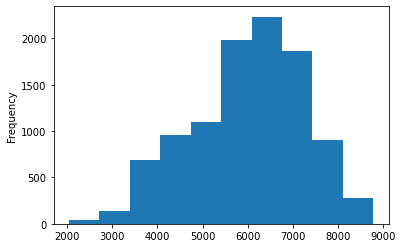

In [105]:
data_df[col].plot.hist()

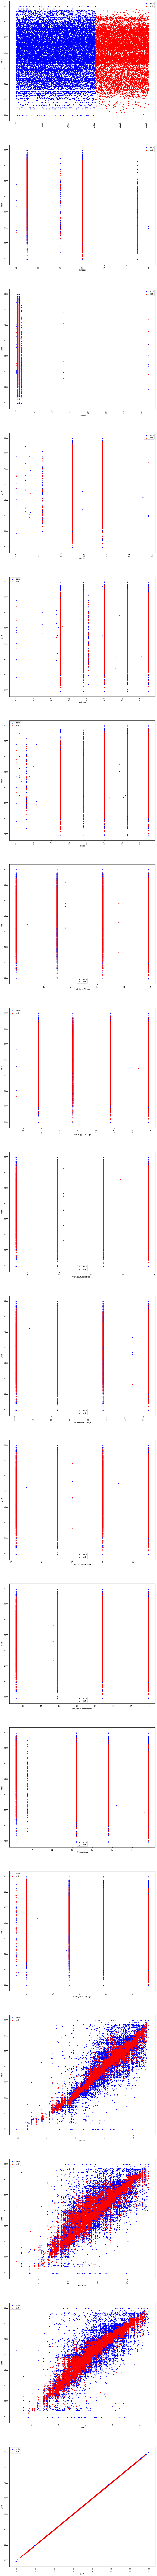

In [106]:
cols = data_df.columns
i1 = 0
i2 = len(cols)
fig, axes = plt.subplots(len(cols[i1:i2]), 1, figsize=(15,15*(i2-i1)))
for i, c in enumerate(cols[i1:i2]):
    data_yp_train_df.get([c, col]).dropna().plot.scatter(x=c, y=col, ax=axes[i], rot=90, color='blue', label='train')
    data_yp_test_df.get([c, col]).dropna().plot.scatter(x=c, y=col, ax=axes[i], rot=90, color='red', label='test')

### Submission

In [107]:
submission_df = data_yp_test_df.get(['id', col])
submission_df.shape

(10194, 2)

In [108]:
submission_df.head()

,id,yield
0,15289,4221.696015
1,15290,6161.236628
2,15291,7053.441396
3,15292,4561.072563
4,15293,3962.125732


In [109]:
submission_df.to_csv('./yield.csv', sep=',', index=False)